<div style="background: linear-gradient(to right, #4b6cb7, #182848); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h1 style="color: white; margin: 0; font-size: 2.5em; font-weight: 700;">GenAIResultsComparator</h1>
    <p style="color: #e0e0e0; margin-top: 10px; font-style: italic; font-size: 1.2em; text-align: center;">A Hands-On Visualization Tutorial</p>
</div>
<br>

Welcome to the <b>GenAIResultsComparator</b> library! This notebook will guide you through its features and demonstrate how to use it for evaluating text generated by Large Language Models (LLMs) against reference texts. We'll cover everything from basic setup to calculating various metrics and visualizing the results.

This library is designed for technical users who want to:

- Compare generated text strings with ground truth versions.
- Utilize a range of reference-based evaluation metrics.
- Process single pairs or batches of text efficiently.
- Visualize comparison results across different models or outputs.

All metrics in this library output scores normalized to a scale of 0 to 1, where 1 indicates a perfect match or high similarity.

For this notebook, we'll assume the library is installed or made accessible via the path modification below.


In [ ]:
import sys
import os

# Get the current working directory of the notebook
notebook_dir = os.getcwd()
# Construct the path to the project root (one level up)
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))

# Add project root to the system path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

Now, that the `llm_metrics` package is confirmed importable, let's continue by importing necessary modules from the library and other common packages.


In [ ]:
# Core library imports
from llm_metrics.ngram_metrics import BLEU, ROUGE
from llm_metrics.text_similarity_metrics import (
    JaccardSimilarity,
)
from llm_metrics.semantic_similarity_metrics import BERTScore
from llm_metrics.utils import prepare_results_dataframe
from llm_metrics.visualize import plot_metric_comparison, plot_radar_comparison, pi

# Standard library and third-party imports
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk  # NLTK is used by some metrics, e.g., JSDivergence and BLEU

# Ensure NLTK data is available (needed for tokenizers, etc.)
# You might need to run this once in your environment
try:
    nltk.data.find("tokenizers/punkt")
except nltk.downloader.DownloadError:
    nltk.download("punkt")

# Configure plots for better display
%matplotlib inline
sns.set_theme(style="whitegrid")

## 1. Comparing Multiple Models & Visualization

A common use case is to compare outputs from different LLMs. The library provides utilities to prepare data for visualization and plotting functions.

**Note:** The visualization module (`llm_metrics.visualize`) is a recent addition and aims to provide basic plotting capabilities.

### 1.1. Simulating Data from Multiple Models

Let's create some hypothetical data representing outputs from three different "models" for a set of reference texts.


In [ ]:
# Define reference texts
references = [
    "The recipe requires two cups of flour, one cup of sugar, and a pinch of salt.",
    "Combine all dry ingredients, then slowly add the wet ingredients. Mix until smooth.",
    "Bake at 350 degrees Fahrenheit for 30 minutes, or until a toothpick inserted into the center comes out clean.",
]

# Simulate outputs from three models
model_outputs = {
    "LLaMA-3-8B": {
        "generated": [
            "Use 2 cups flour, 1 cup sugar, pinch of salt.",
            "Mix dry things, then add wet things. Stir well.",
            "Bake 350 F for 30 mins. Check with toothpick.",
        ],
        "reference": references,
    },
    "GPT-4o-mini": {
        "generated": [
            "The recipe calls for two cups of flour, one cup of sugar, and a little salt.",
            "Combine dry ingredients first, then gradually incorporate wet ingredients. Mix thoroughly.",
            "Bake at 350°F for 30 minutes. Test doneness with a toothpick.",
        ],
        "reference": references,
    },
    "Mistral-Nemo": {
        "generated": [
            "Flour: 2 cups. Sugar: 1 cup. Salt: a bit.",
            "Mix dry, add wet. Stir.",
            "Cook 350F, 30 min. Test it.",
        ],
        "reference": references,
    },
}

### 1.2. Calculating Metrics for Each Model

Now, let's calculate a few metrics for each model's outputs. We'll average the scores across the sample texts for each model.

In [27]:
# Initialize scorers
bleu_scorer = BLEU()
rouge_l_scorer = ROUGE(rouge_types=["rougeL"])  # For ROUGE-L F1
bert_f1_scorer = BERTScore(output_val=["f1"])  # For BERTScore F1
jaccard_scorer = JaccardSimilarity()

# Store results
model_comparison_results = {}

print("Calculating metrics for each model...")
for model_name, data in model_outputs.items():
    print(f"  Processing {model_name}...")
    gen_texts = data["generated"]
    ref_texts = data["reference"]

    # Calculate average scores for each metric
    # Note: For BLEU, corpus-level might be more appropriate for an overall score,
    # but here we average sentence-level scores for consistency in aggregation.
    avg_bleu = np.mean(
        bleu_scorer.batch_calculate(gen_texts, ref_texts, use_corpus_bleu=False)
    )
    avg_rouge_l = np.mean(
        np.array(rouge_l_scorer.batch_calculate(gen_texts, ref_texts))
    )

    # BERTScore can be slow, so let's be mindful
    print(f"    Calculating BERTScore for {model_name} (this might take a moment)...")

    # Extract all values from the BERTScore results using list comprehension
    bert_values = [
        val
        for item in bert_f1_scorer.batch_calculate(gen_texts, ref_texts)
        for _, val in item.items()
    ]
    avg_bert_f1 = np.mean(np.array(bert_values))

    avg_jaccard = np.mean(jaccard_scorer.batch_calculate(gen_texts, ref_texts))

    model_comparison_results[model_name] = {
        "BLEU": avg_bleu,
        "ROUGE_L_F1": avg_rouge_l,
        "BERTScore_F1": avg_bert_f1,
        "Jaccard": avg_jaccard,
    }

print("\nMetrics calculation complete.")
print("Model Comparison Results:")
for model, scores in model_comparison_results.items():
    print(f"\n{model}:")
    pprint(scores)

Calculating metrics for each model...
  Processing LLaMA-3-8B...
    Calculating BERTScore for LLaMA-3-8B (this might take a moment)...
  Processing GPT-4o-mini...
    Calculating BERTScore for GPT-4o-mini (this might take a moment)...
  Processing Mistral-Nemo...
    Calculating BERTScore for Mistral-Nemo (this might take a moment)...

Metrics calculation complete.
Model Comparison Results:

LLaMA-3-8B:
{'BERTScore_F1': np.float64(0.7175530592600504),
 'BLEU': np.float64(0.03789867694099995),
 'Jaccard': np.float64(0.29084967320261434),
 'ROUGE_L_F1': np.float64(0.41974691974691974)}

GPT-4o-mini:
{'BERTScore_F1': np.float64(0.8173813025156657),
 'BLEU': np.float64(0.25341672636506984),
 'Jaccard': np.float64(0.41307189542483663),
 'ROUGE_L_F1': np.float64(0.637320788530466)}

Mistral-Nemo:
{'BERTScore_F1': np.float64(0.5933148960272471),
 'BLEU': np.float64(0.00953135053886115),
 'Jaccard': np.float64(0.0707070707070707),
 'ROUGE_L_F1': np.float64(0.24444444444444444)}


### 1.3. Preparing Data for Visualization

The visualization functions expect data in a specific long-format Pandas DataFrame. We can use the `prepare_results_dataframe` utility.

In [28]:
# The model_comparison_results dictionary is already in a suitable format
# where keys are model names and values are dictionaries of metric_name: score.
# If metrics returned dictionaries (e.g. ROUGE default, BERTScore default),
# prepare_results_dataframe would flatten them (e.g., ROUGE_rouge1, BERTScore_precision).

results_df = prepare_results_dataframe(model_comparison_results)

print("\nPrepared DataFrame for visualization:")
print(results_df.head())


Prepared DataFrame for visualization:
    model_name   metric_name     score
0   LLaMA-3-8B          BLEU  0.037899
1   LLaMA-3-8B    ROUGE_L_F1  0.419747
2   LLaMA-3-8B  BERTScore_F1  0.717553
3   LLaMA-3-8B       Jaccard  0.290850
4  GPT-4o-mini          BLEU  0.253417


### 1.4. Bar Plot: Comparing Models on a Single Metric

Let's compare the models based on their average BERTScore_F1.

<Figure size 800x500 with 0 Axes>

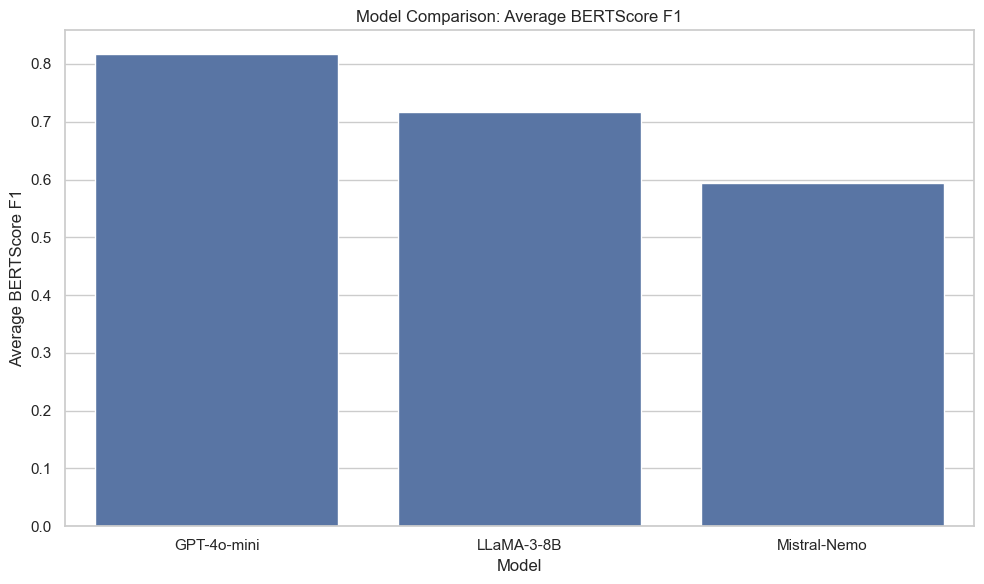

<Figure size 800x500 with 0 Axes>

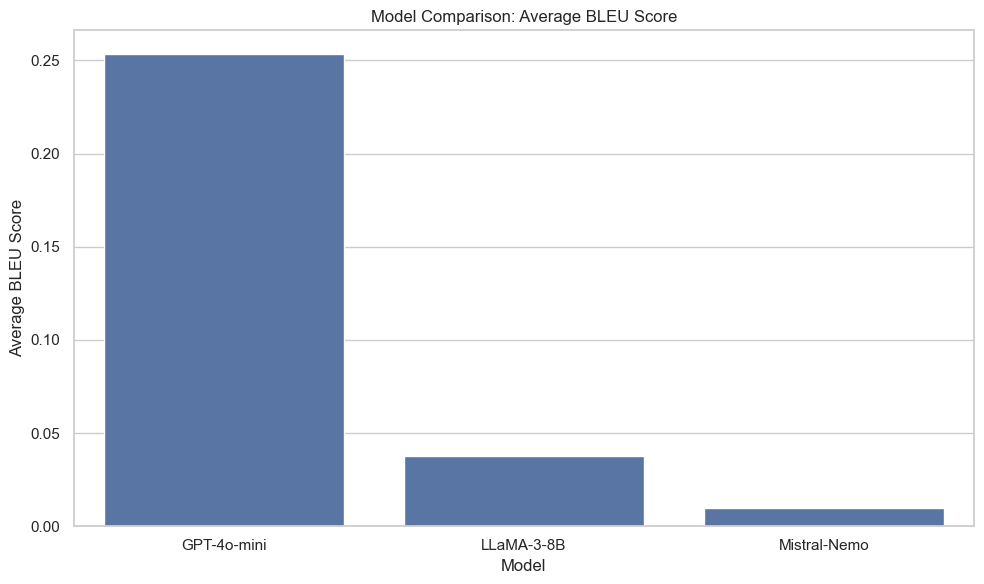

In [31]:
# Ensure plotting libraries are available (already imported, but good practice for standalone viz code)
if plt is None or sns is None or pd is None or np is None:
    print("Matplotlib, Seaborn, Pandas, or Numpy not installed. Skipping bar plot.")
else:
    plt.figure(figsize=(8, 5))
    plot_metric_comparison(
        df=results_df,
        metric_name="BERTScore_F1",  # The metric we want to plot
        title="Model Comparison: Average BERTScore F1",
        ylabel="Average BERTScore F1",
        # aggregate_func=np.mean is default if scores were not pre-aggregated
    )
    plt.show()

    plt.figure(figsize=(8, 5))
    plot_metric_comparison(
        df=results_df,
        metric_name="BLEU",
        title="Model Comparison: Average BLEU Score",
        ylabel="Average BLEU Score",
    )
    plt.show()

### 1.5. Radar Plot: Comparing Models Across Multiple Metrics

A radar plot can give a holistic view of model performance across various metrics.

<Figure size 700x700 with 0 Axes>

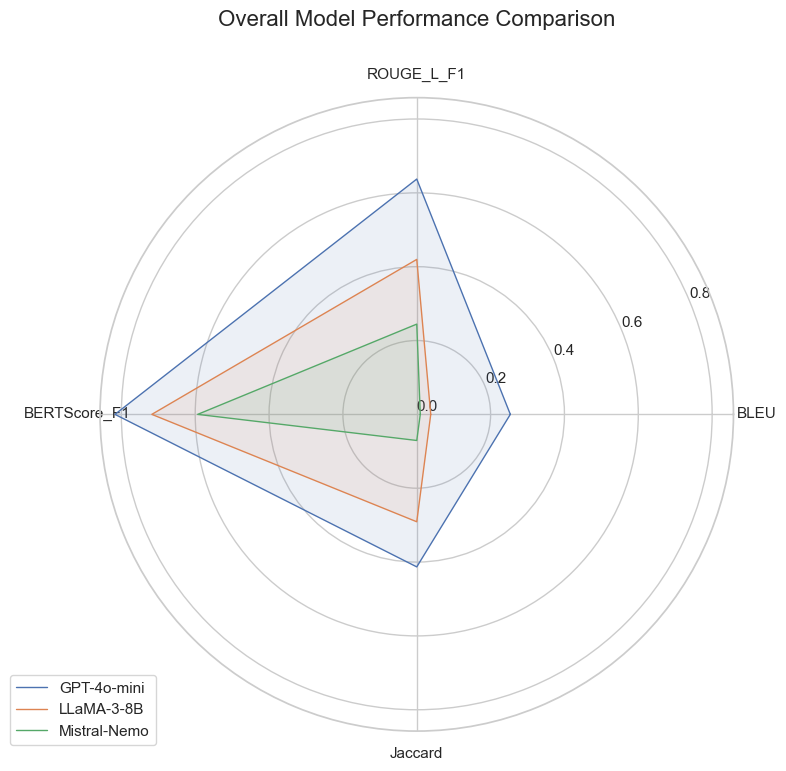

In [34]:
if (
    plt is None or pd is None or np is None or pi is None
):  # pi from math (imported via llm_metrics.visualize)
    print("Matplotlib, Pandas, Numpy or math.pi not available. Skipping radar plot.")
else:
    # We can specify which metrics to include in the radar plot
    metrics_for_radar = ["BLEU", "ROUGE_L_F1", "BERTScore_F1", "Jaccard"]

    plt.figure(figsize=(7, 7))
    plot_radar_comparison(
        df=results_df,
        metrics=metrics_for_radar,  # Specify which metrics to plot
        title="Overall Model Performance Comparison",
        # aggregate_func=np.mean is default if scores were not pre-aggregated
    )
    plt.show()

**Note on Visualizations:** The plotting functions attempt to make reasonable defaults. You can customize titles, labels, figure sizes, and pass other arguments to the underlying Seaborn/Matplotlib functions via `**kwargs`.

## 2. Conclusion

This notebook has demonstrated the core functionalities of the `GenAIResultsComparator` library. You've learned how to:

*   Initialize and use various N-gram, text similarity, and semantic similarity metrics.
*   Calculate scores for single text pairs and batches of texts.
*   Handle different input types like lists and Pandas Series.
*   Understand the structure of outputs (single floats or dictionaries of scores).
*   Prepare results for visualization and generate comparative bar and radar plots.

The library is designed to be extensible, so you can also create your own custom metrics by inheriting from `BaseMetric`. For more advanced use cases, such as prompt-aware evaluation, check the `examples` folder in the library's repository.

We encourage you to explore the library further with your own datasets and LLM outputs. Happy evaluating!